# Writer Process

---

## 1. Set API Keys

In [42]:
import os

# Load API Keys
from config.secret_keys import OPENAI_API_KEY, TAVILY_API_KEY, USER_AGENT

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["USER_AGENT"] = USER_AGENT

## 2. Import Modules

In [43]:
# Construct Vector DB / Create retriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Retrieval Grader
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

# Writer
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# define graph state
from typing import List
from typing_extensions import TypedDict

# define tools
from langchain_community.tools.tavily_search import TavilySearchResults

# define Nodes
from langchain.schema import Document

# construct graph
from langgraph.graph import START, END, StateGraph

## 3. Construct Vector DB 

In [44]:
urls = [
    'https://www.mk.co.kr/news/stock/11209083', # title : 돌아온 외국인에 코스피 모처럼 ‘활짝’…코스닥 700선 탈환
    'https://www.mk.co.kr/news/stock/11209254', # title : 힘 못받는 증시에 밸류업 ETF 두 달째 마이너스 수익률
    'https://www.mk.co.kr/news/stock/11209229', # title : 서학개미 한 달간 1조원 샀는데···테슬라 400달러 붕괴
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name = 'rag-chroma',
    embedding=OpenAIEmbeddings(),
)

retrieve = vectorstore.as_retriever()

## 4. Define Agents

### 4-1. Retrieval Grader

In [45]:
class GradeDocuments(BaseModel):
    """
    Binary score for relevance check on retrieved documents.
    """

    relevance_score : str = Field(
        description="Document are relevant to the question, 'yes' or 'no'"
    )

In [46]:
llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature=0
)
structured_llm = llm.with_structured_output(GradeDocuments)

system_prompt = """
    You are a grader assessing relevance of a retrieved document to a user question. \n 

    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n

    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n

    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "Retreived documents : \n\n {documents} \n\n User question : {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm

### 4-2. Writer

In [47]:
write_prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature=0
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

writer = write_prompt | llm | StrOutputParser()

c:\Users\USER\anaconda3\envs\finpilot\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### 4-3. Hallucination Grader

In [48]:
class GradeHallucination(BaseModel):
    """
    Binary Score for hallunination present in generation answer.
    """

    hallucination_score : str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [49]:
llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature=0
)
structured_llm = llm.with_structured_output(GradeHallucination)

system_prompt = """
    You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 

    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.
"""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "Set of facts : \n\n {documents} \n\n LLM generation : {generation}")
    ]
)

hallucination_grader = hallucination_prompt | structured_llm

### 4-4. Answer Grader

In [50]:
class AnswerGrader(BaseModel):
    """
    Binary Score to assess answer address question.
    """

    answer_score : str = Field(
        description="Answer address the question, 'yes' or 'no'"
    )

In [51]:
llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0
)
structured_llm = llm.with_structured_output(AnswerGrader)

system_prompt = """
    You are a grader assessing whether an answer addresses / resolves a question \n 
    
    Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question.
"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "User question : \n\n {question} \n\n LLM generation : {generation}")
    ]
)

answer_grader = answer_prompt | structured_llm

### 4-5. Query rewriter

In [52]:
llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature=0
)

system_prompt = """
    You a question re-writer that converts an input question to a better version that is optimized for vectorstore retrieval. \n
    
    Look at the input and try to reason about the underlying semantic intent / meaning.
"""
rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        (
            "human",
            "Here is the initial question : \n\n {question} \n Formulation an improved question"
        )
    ]
)

query_rewriter = rewrite_prompt | llm

## 5. Construct Graph

### 5-1. Define Graph State

In [53]:
class State(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question : str
    generation : str
    documents : List[str]

### 5-2. Define Tools

In [54]:
# web search tool
web_search_tool = TavilySearchResults(k=3)

### 5-3. Define Nodes

In [55]:
# Retriever
def retrieve_node(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("[Graph Log] RETRIEVE ...")
    question = state["question"]
    try : 
        prev_documents = state["documents"]
        retrieved_documents = retrieve.invoke(question)
        documents = prev_documents + retrieved_documents
    except:
        documents = retrieve.invoke(question)
    
    return {
        "documents" : documents,
        "question" : question
    }

# writer
def write_node(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    print("[Graph Log] WRITE ...")

    question = state["question"]
    documents = state["documents"]

    generation = writer.invoke({"context" : documents, "question" : question})

    return {
        "documents" : documents,
        "question" : question,
        "generation" : generation
    }

def filter_documents_node(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args : 
        state (dict) : The current graph state

    Returns : 
        state (dict) : Updates documents key with only filterd relevant documents
    """

    print("[Graph Log] FILTER DOCUMENTS ...")

    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    for doc in documents:
        score = retrieval_grader.invoke(
            {"question" : question, "documents" : doc.page_content}
        )
        relevance_grade = score.relevance_score

        if relevance_grade == "yes":
            print("[Relevance Grader Log] GRADE : DOCUMENT RELEVANT")
            filtered_docs.append(doc)
        else:
            print("[Relevance Grader Log] GRADE : DOCUMENT NOT RELEVANT")
            continue
    
    return {"documents" : filtered_docs, "question" : question}

def improve_query_node(state):
    """
    Transform the query to produce a better question.

    Args :
        state (dict) : The current graph state
    
    Returns : 
        state (dict) : Updateds question key with a re-phrase question
    """

    print("[Graph Log] TRANSFORM QUERY ...")

    question = state["question"]
    documents = state["documents"]

    improved_query = query_rewriter.invoke({"question" : question})

    return {"documents" : documents, "question" : improved_query.content}

def web_search_node(state):
    """
    Web search based on the re-phrased question.

    Args :
        state (dict) : The current graph state

    Returns :
        state (dict) : Updates documents key with appended web results
    """

    print("[Graph Log] WEB SEARCH ...")
    question = state["question"]
    documents = state["documents"]

    if isinstance(question, str):
        query = question
    else:
        query = str(question.content) if hasattr(question, 'content') else str(question)

    docs = web_search_tool.invoke({"query" : query})
    web_results = "\n".join([doc["content"] for doc in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents" : documents, "question" : question}

### 5-4. Define Conditional Edge Functions

In [56]:
def decide_write_or_improve_query(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args : 
        state (dict) : The current graph state
    
    Returns :
        str : Binary decision for next node to call
    """

    print("[Graph Log] DETERMINES 'WRITE' OR 'REWRITE QUESTION' ...")

    documents = state["documents"]

    if len(documents) >= 6:
        print(
            "[Graph Log] DECISION : WRITE"
        )
        return "writer"
    else :
        print(
            "[Graph Log] DECISION : REWRITE QUESTION"
        )
        return "improve_query"

def decide_to_regenerate_or_rewrite_query_or_end(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict) : The current graph state
    
    Returns :
        str : Decision for next node to call
    """

    print("[Graph Log] CHECK HALLUCINATIONS ...")

    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents" : documents, "generation" : generation}
    )
    hallucination_grade = score.hallucination_score

    if hallucination_grade == "yes":
        print("[Graph Log] DECISION : ANSWER IS GROUNDED IN DOCUMENTS")

        print("[Graph Log] CHECK ANSWER IS USEFUL OR NOT ...")

        score = answer_grader.invoke(
            {"question" : question, "generation" : generation}
        )
        answer_grade = score.answer_score

        if answer_grade == "yes":
            print("[Graph Log] DECISION : GENERATION ADDRESSES QUESTION")

            return "useful"
        else :
            print("[Graph Log] DECISION : GENERATION DOES NOT ADDRESS QUESTION")

            return "not useful"
    else:
        print("[Graph Log] DECISION : GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY")
        
        return "not supported"


### 5-5. Construct Graph

In [57]:
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("retriever", retrieve_node)
workflow.add_node("filter_documents", filter_documents_node)
workflow.add_node("writer", write_node)
workflow.add_node("improve_query", improve_query_node)
workflow.add_node("web_search", web_search_node)

# connects edges
workflow.add_edge(START, "retriever")
workflow.add_edge("retriever", "filter_documents")
workflow.add_conditional_edges(
    "filter_documents",
    decide_write_or_improve_query,
    {
        "writer" : "writer",
        "improve_query" : "improve_query"
    },
)
workflow.add_conditional_edges(
    "writer",
    decide_to_regenerate_or_rewrite_query_or_end,
    {
        "not supported" : "writer",
        "useful" : END,
        "not useful" : "improve_query"
    }
)
workflow.add_edge("improve_query", "web_search")
workflow.add_edge("web_search", "retriever")

app = workflow.compile()

### 5-6. Visualize Graph

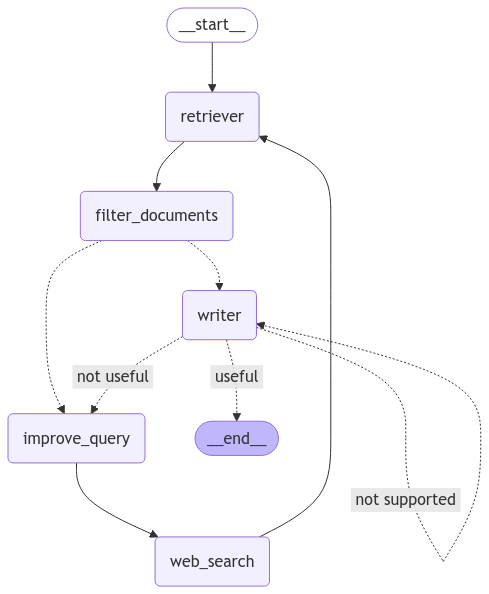

In [58]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 6. Test

In [59]:
# Run
inputs = {"question": "코스피와 코스닥에 대한 최근 이슈에 대한 인사이트를 작성해줘"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}' : '{value}")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

[Graph Log] RETRIEVE ...
Node 'retriever' : '{'documents': [Document(metadata={'description': '코스피가 외국인과 기관투자자의 쌍끌이 매수에 2440선을 회복했다. 코스닥 지수는 장중 2%대 상승하며 700선을 탈환했다. 3일 오전 11시 30분 현재 코스피는 전일 대비 45.76포인트(1.91%) 오른 2444.70을 가리키고 있다. 간밤 뉴욕증시는 약세로 마감했으나 국내 증시는 상승하는 모습이다. 지난 2일(현지시간) 뉴욕증시에서 다우지수는 전일 ', 'language': 'ko', 'source': 'https://www.mk.co.kr/news/stock/11209083', 'title': '돌아온 외국인에 코스피 모처럼 ‘활짝’…코스닥 700선 탈환 - 매일경제'}, page_content='돌아온 외국인에 코스피 모처럼 ‘활짝’…코스닥 700선 탈환\n\n\n\n\n\n\n뉴스 요약쏙\n\n\n뉴스 요약쏙\nAI 요약은 OpenAI의 최신 기술을 활용해 핵심 내용을 빠르고 정확하게 제공합니다. 전체 맥락을 이해하려면 기사 본문을 함께 확인하는 것이 좋습니다.\n닫기'), Document(metadata={'description': '코스피가 외국인과 기관투자자의 쌍끌이 매수에 2440선을 회복했다. 코스닥 지수는 장중 2%대 상승하며 700선을 탈환했다. 3일 오전 11시 30분 현재 코스피는 전일 대비 45.76포인트(1.91%) 오른 2444.70을 가리키고 있다. 간밤 뉴욕증시는 약세로 마감했으나 국내 증시는 상승하는 모습이다. 지난 2일(현지시간) 뉴욕증시에서 다우지수는 전일 ', 'language': 'ko', 'source': 'https://www.mk.co.kr/news/stock/11209083', 'title': '돌아온 외국인에 코스피 모처럼 ‘활짝’…코스닥 700선 탈환 - 매일경제'}, page_content='돌아온 외국인에 코스피 모처럼 ‘활짝’…코스